In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
df = pd.read_csv('datasets/dataset_train.csv')[['Hogwarts House', 'Herbology', 'Defense Against the Dark Arts',
       'Divination', 'Muggle Studies', 'Ancient Runes', 'History of Magic',
       'Transfiguration', 'Care of Magical Creatures', 'Charms', 'Flying']]
df.head()

,Hogwarts House,Herbology,Defense Against the Dark Arts,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Care of Magical Creatures,Charms,Flying
0,Ravenclaw,5.727180,4.878861,4.722,272.035831,532.484226,5.231058,1039.788281,0.715939,-232.79405,-26.89
1,Slytherin,-5.987446,5.520605,-5.612,-487.340557,367.760303,4.107170,1058.944592,0.091674,-252.18425,-113.45
2,Ravenclaw,7.725017,3.660761,6.140,664.893521,602.585284,3.555579,1088.088348,-0.515327,-227.34265,30.42
3,Gryffindor,-6.497214,-6.977428,4.026,-537.001128,523.982133,-4.809637,920.391449,-0.014040,-256.84675,200.64
4,Gryffindor,-7.820623,NaN,2.236,-444.262537,599.324514,-3.444377,937.434724,-0.264070,-256.38730,157.98


In [31]:
# for train: Ravenclaw -> Slytherin -> Gryffindor
target = ['Ravenclaw', 'Slytherin', 'Gryffindor']
df = df[['Hogwarts House', 'Muggle Studies', 'Charms', 'Divination', 'Flying', 'History of Magic', 'Transfiguration']]
df.head()

,Hogwarts House,Muggle Studies,Charms,Divination,Flying,History of Magic,Transfiguration
0,Ravenclaw,272.035831,-232.79405,4.722,-26.89,5.231058,1039.788281
1,Slytherin,-487.340557,-252.18425,-5.612,-113.45,4.107170,1058.944592
2,Ravenclaw,664.893521,-227.34265,6.140,30.42,3.555579,1088.088348
3,Gryffindor,-537.001128,-256.84675,4.026,200.64,-4.809637,920.391449
4,Gryffindor,-444.262537,-256.38730,2.236,157.98,-3.444377,937.434724


In [32]:
df.shape[0]

1600

In [33]:
df.shape[0] - df.dropna().shape[0]

148

In [34]:
df = df.dropna()

In [35]:
df.shape

(1452, 7)

In [36]:
div = 0.9
df_test = df.iloc[int(df.shape[0] * div):]
df = df.iloc[:int(df.shape[0] * div)]
df.shape

(1306, 7)

In [37]:
def get_minmax(x):
    x_minmax = np.zeros([x.shape[1], 2], np.float32)
    for i in range(x.shape[1]):
        x_minmax[i] = [x[:, i].min(), x[:, i].max()]
    return x_minmax

def normalization(target, val_min, val_max):
    return (target - val_min) / (val_max - val_min)

def set_xnorm(x, x_minmax):
    for i in range(x.shape[1]):
        x[:, i] = normalization(x[:, i], *x_minmax[i])

y = df.values[:, 0]
x = df.values[:, 1:].astype(np.float32)
x_minmax = get_minmax(x)
set_xnorm(x, x_minmax)
bias = np.ones((x.shape[0], 1))
x = np.concatenate((x, bias), 1)

In [38]:
def sigmoid(predict):
    sigmoid = 1 / (1 + np.exp(-predict))
    return sigmoid

# def loss_log(y, predict):
#     loss_log = -np.mean(y * np.log(predict) +
#                         (1 - y) * np.log(1 - predict))
#     return loss_log

# def loss_log(predict, y, target):
#     y =  np.array(list(map(lambda x: 1 if x == target else 0, y)))
#     # if target == 'Ravenclaw':
#     #     y =  np.array(list(map(lambda x: 1 if x == target else 0, y)))
#     # else:
#     #     y =  np.array(list(map(lambda x: 0 if x == target else 1, y)))

#     loss_log = -np.mean(y * np.log(predict) +
#                         (1 - y) * np.log(1 - predict))
#     return loss_log

def loss_log(predict, target):
    loss_log = -np.mean(target * np.log(predict) +
                        (1 - target) * np.log(1 - predict))
    return loss_log

def get_vecpredict(x, weight, i):
    predict = sigmoid(np.concatenate([x[:, (i * 2):(i * 2 + 2)],
                                        x[:, -1].reshape(-1, 1)],
                                        axis=1) @\
                        weight[(i * 3):(i * 3 + 3)])
    return predict

# def get_house(i):
#     if i == 0:
#         house = 'Ravenclaw'
#     elif i == 1:
#         house = 'Slytherin'
#     else:
#         house = 'Gryffindor'
#     return house

def get_vectarget(y, target):
    # i = get_house(i)
    target =  np.array(list(map(lambda x: 1 if x == target else 0, y)))
    return target

def set_errorepoch(error, epoch, x, weight, y, target):
    for i in range(3):
        error[epoch][i] = loss_log(get_vecpredict(x, weight, i),
                                    get_vectarget(y, target[i]))



In [39]:
def predict_error(predict, y, i, target):
    # error = predict - int(y[i] == get_house(j))
    error = predict - int(y[i] == target)
    return error

def sigmoid_derivative(predict):
    derivative = predict * (1 - predict)
    return derivative

def feature_slice(x, i, j):
    slc = np.concatenate([x[i][(j * 2):(j * 2 + 2)],
                        [x[i][-1]]])
    return slc

def get_housepredict(x, weight, i, j):
    predict = sigmoid(np.concatenate([x[i][(j * 2):(j * 2 + 2)],
                                    [1]]) @ weight[(j * 3):(j * 3 + 3)])
    return predict

def fill_delta(delta, x, weight, y, i, target):
    for j in range(3):
        # predict = sigmoid(np.concatenate([x[i][(j * 2):(j * 2 + 2)],
        #                             [1]]) @ weight[(j * 3):(j * 3 + 3)])
        predict = get_housepredict(x, weight, i, j)
        delta[(j * 3):(j * 3 + 3)] += predict_error(predict, y, i, target[j]) *\
                                        sigmoid_derivative(predict) *\
                                        feature_slice(x, i, j)


weight = np.random.random(x.shape[1] + 2)
delta = np.zeros(weight.size, np.float32)
# alpha = np.array([0.01] * weight.size, np.float32) #maybe change to scalar
alpha = 0.01
epochs = 200
error = np.zeros([epochs, 3], np.float32)
for epoch in range(epochs):
    set_errorepoch(error, epoch, x, weight, y, target)
    ## need change for one calculation vectarget

    for i in range(x.shape[0]):
        fill_delta(delta, x, weight, y, i, target)
    weight -= delta * alpha
    delta[:] = 0


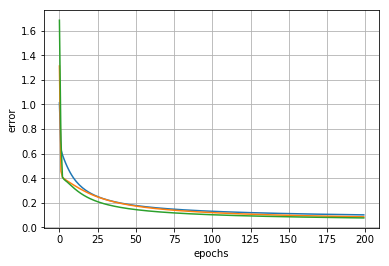

In [40]:
# plt.plot(range(epochs), error[:, 0])
plt.plot(range(epochs), error)
plt.xlabel('epochs')
plt.ylabel('error')
plt.grid()
plt.show()

In [41]:
error[-1]

array([0.10205781, 0.08625738, 0.07732066], dtype=float32)

In [42]:
weight

array([ 5.82286922,  5.59824139, -6.66953541, -8.33402767, -2.71378221,
        4.30942528, -5.28286294, -5.76550976,  4.57572974])

In [43]:
df_test.head(20)

,Hogwarts House,Muggle Studies,Charms,Divination,Flying,History of Magic,Transfiguration
1437,Gryffindor,-670.368577,-254.67808,5.109,246.76,-7.545058,928.476711
1438,Hufflepuff,-495.832714,-244.13536,5.286,26.88,4.153129,1043.578570
1439,Hufflepuff,-602.548895,-245.04629,4.562,-51.42,4.658685,1060.349507
1440,Gryffindor,-466.889352,-251.92547,5.857,227.01,-6.312408,944.991478
1441,Slytherin,-840.602433,-248.78562,-4.861,-99.87,6.083082,1071.843317
1443,Gryffindor,-510.491761,-255.12874,3.526,153.59,-3.690399,946.706549
1444,Slytherin,799.658514,-228.39853,6.955,-7.29,3.671743,1084.864485
1445,Gryffindor,-1040.739017,-255.42549,1.734,225.00,-6.810648,953.199757
1446,Gryffindor,-834.202775,-243.72415,6.217,-31.21,3.244444,1078.451414
1447,Slytherin,-565.091120,-251.22853,-5.022,-98.27,5.295359,1053.462465


In [45]:
string = 1443
ins = df_test.loc[string].values[1:].astype(np.float32)
ins
# np.concatenate([ins[0:2], [1]])

array([-510.49176  , -255.12874  ,    3.526    ,  153.59     ,
         -3.6903992,  946.70654  ], dtype=float32)

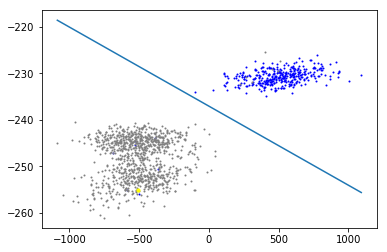

In [46]:
plt.scatter(df[df['Hogwarts House'] == 'Ravenclaw']['Muggle Studies'], df[df['Hogwarts House'] == 'Ravenclaw']['Charms'], color='blue', s=1)
plt.scatter(df[df['Hogwarts House'] != 'Ravenclaw']['Muggle Studies'], df[df['Hogwarts House'] != 'Ravenclaw']['Charms'], color='gray', s=1)

divider_x0 = x_minmax[0]
divider_x1 = -(normalization(x_minmax[0], *x_minmax[0]) * weight[0] + weight[2]) / weight[1]
divider_x1 = divider_x1 * (x_minmax[1][1] - x_minmax[1][0]) + x_minmax[1][0]
plt.plot(divider_x0, divider_x1)

plt.scatter(ins[0], ins[1], color='yellow', s=10)

plt.show()

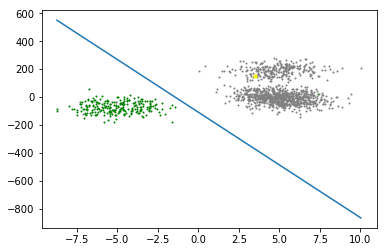

In [47]:
plt.scatter(df[df['Hogwarts House'] == 'Slytherin']['Divination'], df[df['Hogwarts House'] == 'Slytherin']['Flying'], color='green', s=1)
plt.scatter(df[df['Hogwarts House'] != 'Slytherin']['Divination'], df[df['Hogwarts House'] != 'Slytherin']['Flying'], color='gray', s=1)

divider_x0 = x_minmax[2]
divider_x1 = -(normalization(x_minmax[2], *x_minmax[2]) * weight[3] + weight[5]) / weight[4]
divider_x1 = divider_x1 * (x_minmax[3][1] - x_minmax[3][0]) + x_minmax[3][0]
plt.plot(divider_x0, divider_x1)

plt.scatter(ins[2], ins[3], color='yellow', s=10)

plt.show()

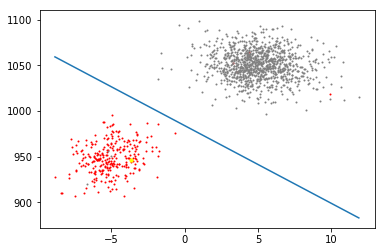

In [48]:
plt.scatter(df[df['Hogwarts House'] == 'Gryffindor']['History of Magic'], df[df['Hogwarts House'] == 'Gryffindor']['Transfiguration'], color='red', s=1)
plt.scatter(df[df['Hogwarts House'] != 'Gryffindor']['History of Magic'], df[df['Hogwarts House'] != 'Gryffindor']['Transfiguration'], color='gray', s=1)

divider_x0 = x_minmax[4]
divider_x1 = -(normalization(x_minmax[4], *x_minmax[4]) * weight[6] + weight[8]) / weight[7]
divider_x1 = divider_x1 * (x_minmax[5][1] - x_minmax[5][0]) + x_minmax[5][0]
plt.plot(divider_x0, divider_x1)

plt.scatter(ins[4], ins[5], color='yellow', s=10)

plt.show()

In [49]:
ins[0] = normalization(ins[0], *x_minmax[0])
ins[1] = normalization(ins[1], *x_minmax[1])
ins[2] = normalization(ins[2], *x_minmax[2])
ins[3] = normalization(ins[3], *x_minmax[3])
ins[4] = normalization(ins[4], *x_minmax[4])
ins[5] = normalization(ins[5], *x_minmax[5])
# ins = normalization(ins, *x_minmax)

In [50]:
# house = ['Ravenclaw', 'Slytherin', 'Gryffindor']
probability = np.zeros(3, np.float32)
for i in range(probability.size):
    probability[i] = sigmoid(np.concatenate([ins[(i * 2):(i * 2 + 2)],
                                            [1]]) @\
                                            weight[(i * 3):(i * 3 + 3)])
if np.all([i < 0.5 for i in probability]):
    house = 'Hufflepuff'
else:
    house = target[np.where(probability == np.max(probability))[0][0]]
house

'Gryffindor'